# Word Vector

In [1]:
import codecs
import numpy as np
import tensorflow as tf

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [19]:
# data
en_vocab = codecs.open("../ted-data/en.vocab","r","utf-8")
word = []
for line in en_vocab:
    line = line.strip("\n")
    word.append(line)

In [22]:
word[0]

'<unk>'

In [30]:
word_to_id = {}
for index,w in enumerate(word):
    word_to_id[w] = index
en_vocab_size = len(word_to_id)

### 1 one-hot

In [31]:
def get_id(word):
    return word_to_id[word] if word in word_to_id else word_to_id["<unk>"]
def OneHotVector(word):
    word_id = get_id(word)
    word_vector = np.zeros(en_vocab_size)
    word_vector[word_id] = 1
    return word_vector

In [36]:
OneHotVector("<unk>")

array([1., 0., 0., ..., 0., 0., 0.])

### 2 based on SVD

> 降维，让词之间产生联系

### 2.1 词-文档矩阵

- 最终所得矩阵维度为：V（词汇数量） x M(文档个数)
- 维度超大，必须要优化

### 2.2 词词共现矩阵

In [39]:
corpus_raw = 'He is the king . The king is royal . She is the royal queen'

#convert to lower case
corpus_raw = corpus_raw.lower()

#create a list to determine the index of every word
words = []
for word in corpus_raw.split():
    if word != '.':
        words.append(word)
words = set(words)

In [40]:
words

{'he', 'is', 'king', 'queen', 'royal', 'she', 'the'}

In [41]:
# create dicts of index and words
word2int = {}
int2word = {}
vocab_size = len(words)
for i,word in enumerate(words):
    word2int[word] = i
    int2word[i] = word

In [42]:
#convert sentence to words
raw_sentences = corpus_raw.split('.')
sentences = []
for sentence in raw_sentences:
    sentences.append(sentence.split())
#every element of sentences is the words of a sentence

In [43]:
sentences

[['he', 'is', 'the', 'king'],
 ['the', 'king', 'is', 'royal'],
 ['she', 'is', 'the', 'royal', 'queen']]

In [44]:
#create word-word matrix
WINDOW_SIZE = 1
words_matrix = np.zeros((vocab_size,vocab_size))
for sentence in sentences:
    for word_index,word in enumerate(sentence):
        index = word2int[word]
        for nb_word in sentence[max(word_index - WINDOW_SIZE,0) : min(word_index + WINDOW_SIZE,len(sentence)) + 1]:
            if nb_word != word:
                target_index = word2int[nb_word]
                words_matrix[index][target_index] += 1

In [45]:
words_matrix

array([[0., 1., 2., 1., 1., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [2., 0., 0., 2., 0., 0., 1.],
       [1., 0., 2., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 1., 0.]])

### 3 skip-gram

In [ ]:
#create traing data
data = []

WINDOW_SIZE = 2

for sentence in sentences:
    for word_index,word in enumerate(sentence):
        for nb_word in sentence[max(word_index - WINDOW_SIZE,0) : min(word_index + WINDOW_SIZE,len(sentence)) + 1]:
            #the reason of adding 1 is that ending isn't being taken into consideration
            if nb_word != word:
                data.append([word,nb_word])
                # the couple of input and output

In [ ]:
#convert couple of word to numbers ,then continue to turn from numbers to one-hot
def to_one_hot(data_point_index,vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [ ]:
x_train = []
y_train = []

for data_word in data:
    x_train.append(to_one_hot(word2int[data_word[0]],vocab_size))
    y_train.append(to_one_hot(word2int[data_word[1]],vocab_size))

#convert x and y to nunmpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [ ]:
#make tensorflow mode
x = tf.placeholder(tf.float32,shape=(None,vocab_size))
y_label = tf.placeholder(tf.float32,shape=(None,vocab_size))

EMBEDDING_DIM = 5 #embedding dimension
w1 = tf.Variable(tf.random_normal([vocab_size,EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([EMBEDDING_DIM]))

hidden_representation = tf.add(tf.matmul(x,w1),b1)
# hidden_representation stands for embedding vector

#deal with hidden layer
#predict the surrounding words
w2 = tf.Variable(tf.random_normal([EMBEDDING_DIM,vocab_size]))
b2 = tf.Variable(tf.random_normal([vocab_size]))
prediction = tf.nn.softmax(tf.add(tf.matmul(hidden_representation,w2),b2))

In [ ]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# cost function
cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(y_label*tf.log(prediction),reduction_indices=[1]))

# optimization function
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy_loss)

# iteration
n_iters = 10000
for i in range(n_iters):
    sess.run(train_step,feed_dict={x:x_train,y_label:y_train})
    print("%diter,",i)
    print('loss is :',sess.run(cross_entropy_loss,feed_dict={x:x_train,y_label:y_train}))

> 补充

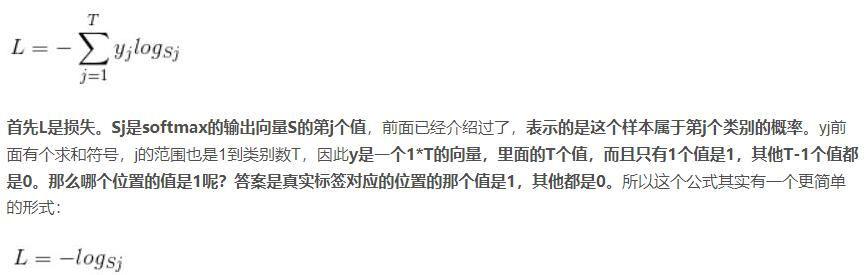

In [ ]:
embedding,predict = sess.run([hidden_representation,prediction],feed_dict={x:x_train,y_label:y_train})
print(embedding.shape)
print(vocab_size)
# print(predict)
print(sum(predict[1])  )
# print(y_train)